## Use expression data to see which expression levels ceratin patients have in common
First, start by making a GMM out of all of the data and produce GMM labels based on which class they belong to. Then use these labels and the original training points to make a decision tree which tries to predict which class each one belongs to. Then create a vizualization for the tree and also a bar/hist for the frequency of each class. Depending on the highest entropy decisions, I will create distributions for each of their components.

### Imports

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.tree._tree import TREE_LEAF
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
import seaborn as sns
from scipy import stats
from sklearn.tree import _tree
from itertools import combinations
from sklearn.neighbors import KernelDensity
import TumorDecon as td

### Format Data

In [3]:
df = pd.read_excel('C:/Users/NathanGrant/Programs/TripodsREU/data/uvm_tcga_pan_can_atlas_2018/data_RNA_Seq_v2_expression_median_excel.xlsx',index_col="Hugo_Symbol")
df= df.T
gene_expression = df.values

### BGMM fitting and label generating

In [4]:
bgm = BayesianGaussianMixture(n_components=2,covariance_type='diag')
bgm_classes = bgm.fit_predict(gene_expression)
print(bgm_classes)


[1 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1
 1 1 0 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1
 1 1 0 1 0 0]


### Split into test and train data for Decision Tree

In [5]:

# Randomly take 20% of data points for testing the decision tree thats created
X_train, X_test, y_train, y_test = train_test_split(gene_expression, bgm_classes, test_size=0.2, random_state=42)

### Train Decision Tree on train test data

In [6]:
from sklearn.tree import DecisionTreeClassifier
max_depth = 4
tree = DecisionTreeClassifier(random_state=1, max_depth=max_depth)
tree.fit(X_train, y_train)
tree.score(X_test,y_test)

0.9375

### Vizualize which genes branches were split on

In [7]:
bgm = BayesianGaussianMixture(n_components=2,covariance_type='diag', n_init=3, random_state=1)
bgm_classes = bgm.fit_predict(gene_expression)

X_train, X_test, y_train, y_test = train_test_split(gene_expression, bgm_classes, test_size=0.2, random_state=1)
tree = DecisionTreeClassifier(random_state=1, max_depth=7)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [8]:
#gm = BayesianGaussianMixture(n_components=2,covariance_type='diag', n_init=3, random_state=1)
s = bgm.sample()
print(bgm.predict_proba(s[0]))

[[1. 0.]]


In [170]:
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    #print ("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

def plot_dist_and_test(num_classes, gene_name,bgm_classes):
    colors= ["b","r","g","y"]
    temp_express = df[gene_name].values
    x = [[temp_express[i] for i in  range(len(temp_express)) if bgm_classes[i] == c] for c in range(num_classes)]
    [sns.kdeplot(x[i], shade=True, color=colors[i]) for i in range(num_classes)]
    print(gene_name)
    for c in combinations(range(len(x)),2):
        print("t-test between ",c[0],"and ",c[1],": ", stats.ttest_ind(x[c[0]],x[c[1]],equal_var=False))
    

In [10]:
tree_to_code(tree, [str(a) for a in df.columns])

  if ZNF628 <= 485.09400939941406:
    return [[42.  0.]]
  else:  # if ZNF628 > 485.09400939941406
    return [[ 0. 22.]]


In [11]:
df.columns[tree.tree_.feature[0]]

'ZNF628'

### Create distributions for ZNF628 gene
From NCBI: Zinc finger proteins (ZNFs), which bind nucleic acids, perform many key functions, the most important of which is regulating transcription

ZNF628
t-test between  0 and  1 :  Ttest_indResult(statistic=-11.23849912638264, pvalue=1.2741231907720755e-12)


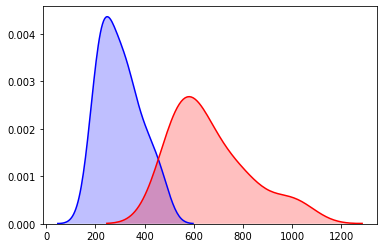

In [12]:
plot_dist_and_test(2, 'ZNF628')

Use the gmm to get the probabilioty that they belong to each oof the distributions that they are assigned to. Then take this data and make a weighted decision tree where each of the data points is weighted based off of the certanty that its a part of the class.

### Use PCA and same techniques as above to try to determine gene expression differences between groups

In [13]:
pca_comp=3
pca = PCA(n_components=pca_comp)
pca_express = pca.fit_transform(gene_expression)
bgm = BayesianGaussianMixture(n_components=3, n_init=3, random_state=1)
bgm_classes = bgm.fit_predict(pca_express)

X_train, X_test, y_train, y_test = train_test_split(gene_expression, bgm_classes, test_size=0.2, random_state=1)
tree = DecisionTreeClassifier(random_state=1, max_depth=7)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [14]:
tree_to_code(tree, [str(a) for a in df.columns])

  if CHMP6 <= 1392.8200073242188:
    if RPL23 <= 24820.349609375:
      return [[17.  0.  0.]]
    else:  # if RPL23 > 24820.349609375
      if LEPR <= 39.691500663757324:
        return [[ 0. 27.  0.]]
      else:  # if LEPR > 39.691500663757324
        if SOX5 <= 76.36389923095703:
          return [[0. 0. 1.]]
        else:  # if SOX5 > 76.36389923095703
          return [[1. 0. 0.]]
  else:  # if CHMP6 > 1392.8200073242188
    return [[ 0.  0. 18.]]


### 2D Slice of PCA transform

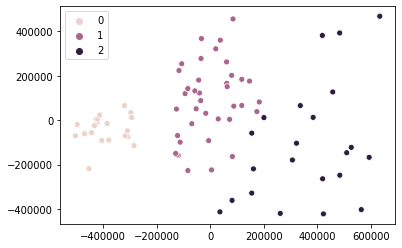

In [15]:
sns.scatterplot(pca_express[:,0],pca_express[:,1],hue=bgm_classes)

In [16]:
pca.explained_variance_

array([8.74654755e+10, 4.06513658e+10, 1.68456330e+10])

### High Entropy Genes

ATP5G2
t-test between  0 and  1 :  Ttest_indResult(statistic=-8.966880119381612, pvalue=8.330120769056402e-12)
t-test between  0 and  2 :  Ttest_indResult(statistic=-7.931243095188477, pvalue=5.138181718175854e-08)
t-test between  1 and  2 :  Ttest_indResult(statistic=-2.7031785264292734, pvalue=0.010814126556900096)


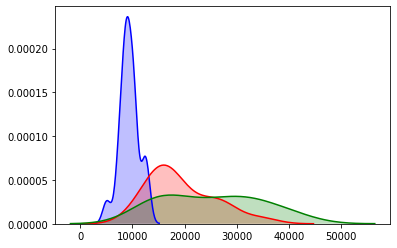

In [17]:
plot_dist_and_test(3, 'ATP5G2')

This gene encodes a subunit of mitochondrial ATP synthase. Mitochondrial ATP synthase catalyzes ATP synthesis, utilizing an electrochemical gradient of protons across the inner membrane during oxidative phosphorylation. ATP synthase is composed of two linked multi-subunit complexes: the soluble catalytic core, F1, and the membrane-spanning component, Fo, comprising the proton channel. The catalytic portion of mitochondrial ATP synthase consists of 5 different subunits (alpha, beta, gamma, delta, and epsilon) assembled with a stoichiometry of 3 alpha, 3 beta, and single representatives of the gamma, delta, and epsilon subunits. The proton channel likely has nine subunits (a, b, c, d, e, f, g, F6 and 8). There are three separate genes which encode subunit c of the proton channel and they specify precursors with different import sequences but identical mature proteins. The protein encoded by this gene is one of three precursors of subunit c.[provided by RefSeq, Jan 2018]



Not sure what this would have to do with UVM.

CHMP6
t-test between  0 and  1 :  Ttest_indResult(statistic=-4.213471192230282, pvalue=9.260187277570716e-05)
t-test between  0 and  2 :  Ttest_indResult(statistic=-12.25900259496701, pvalue=1.0570752718803934e-12)
t-test between  1 and  2 :  Ttest_indResult(statistic=-9.147040657973747, pvalue=1.2968076775815735e-10)


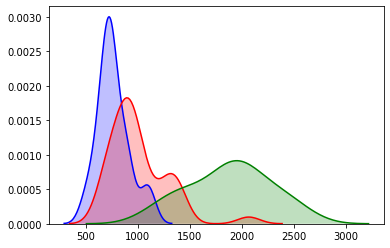

In [18]:
plot_dist_and_test(3, 'CHMP6')

This gene encodes a member of the chromatin-modifying protein/charged multivesicular body protein family. Proteins in this family are part of the ESCRT-III (endosomal sorting complex required for transport III) which degrades surface receptors, and in biosynthesis of endosomes.[provided by RefSeq, Mar 2012]

Not sure what this would have to do with UVM

RPL23
t-test between  0 and  1 :  Ttest_indResult(statistic=-9.376430933264857, pvalue=9.389613908949628e-13)
t-test between  0 and  2 :  Ttest_indResult(statistic=-7.222195232677267, pvalue=8.995987522875484e-08)
t-test between  1 and  2 :  Ttest_indResult(statistic=0.18785792476103316, pvalue=0.8518544598301784)


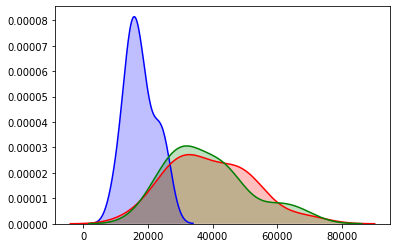

In [19]:
plot_dist_and_test(3, 'RPL23')

Ribosomes, the organelles that catalyze protein synthesis, consist of a small 40S subunit and a large 60S subunit. Together these subunits are composed of 4 RNA species and approximately 80 structurally distinct proteins. This gene encodes a ribosomal protein that is a component of the 60S subunit. The protein belongs to the L14P family of ribosomal proteins. It is located in the cytoplasm. This gene has been referred to as rpL17 because the encoded protein shares amino acid identity with ribosomal protein L17 from Saccharomyces cerevisiae; however, its official symbol is RPL23. As is typical for genes encoding ribosomal proteins, there are multiple processed pseudogenes of this gene dispersed through the genome. [provided by RefSeq, Jul 2008]

Not sure what this would have to do with UVM

ZNF628
t-test between  0 and  1 :  Ttest_indResult(statistic=-6.21039198610986, pvalue=9.65673455219518e-08)
t-test between  0 and  2 :  Ttest_indResult(statistic=-11.71736656194419, pvalue=2.144984242746058e-11)
t-test between  1 and  2 :  Ttest_indResult(statistic=-7.3218451491311916, pvalue=1.837085738816514e-08)


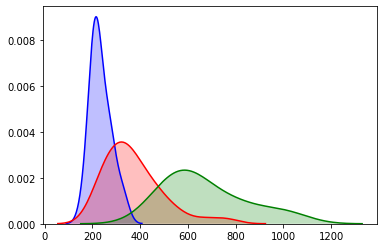

In [20]:
plot_dist_and_test(3, 'ZNF628')

Zinc finger proteins (ZNFs), which bind nucleic acids, perform many key functions, the most important of which is regulating transcription. See ZNF91 (MIM 603971) for general information on ZNFs.[supplied by OMIM, Mar 2008]

Not sure what this would have to do with UVM

### Generate points from BGMM and use same techniques to see more smoothed out distributions

In [21]:
generated_samples, generated_labels = bgm.sample(1000)
rev_gen_samples = pca.inverse_transform(generated_samples)
gen_tree = DecisionTreeClassifier(max_depth=2, random_state=1)
gen_tree.fit(generated_samples ,generated_labels)
tree_to_code(gen_tree, [str(a) for a in df.columns])

  if UBE2Q2P2 <= -185230.40625:
    if RPL41P2 <= 204184.25:
      return [[247.  12.   0.]]
    else:  # if RPL41P2 > 204184.25
      return [[0. 7. 0.]]
  else:  # if UBE2Q2P2 > -185230.40625
    if UBE2Q2P2 <= 175289.1640625:
      return [[ 19. 424.  65.]]
    else:  # if UBE2Q2P2 > 175289.1640625
      return [[  0.  13. 213.]]


UBE2Q2P2
t-test between  0 and  1 :  Ttest_indResult(statistic=-0.15215103923402593, pvalue=0.8797697240887734)
t-test between  0 and  2 :  Ttest_indResult(statistic=1.8813277226004772, pvalue=0.06775479027622504)
t-test between  1 and  2 :  Ttest_indResult(statistic=2.2609119083333016, pvalue=0.027767818536256053)


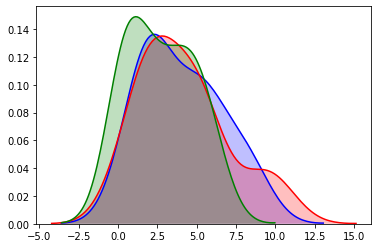

In [22]:
plot_dist_and_test(3, 'UBE2Q2P2')

In [25]:
for i in range(len(df.columns)):
    if df.columns[i] == 'UBE2Q2P2':
        print(i,df.columns[i])

0 UBE2Q2P2


t-test between  0 and  1 :  Ttest_indResult(statistic=-6.563109178495857, pvalue=1.0755717505837935e-10)
t-test between  0 and  2 :  Ttest_indResult(statistic=13.803135499566864, pvalue=4.336909190804523e-35)
t-test between  1 and  2 :  Ttest_indResult(statistic=16.286357186224002, pvalue=2.7746515562501566e-49)


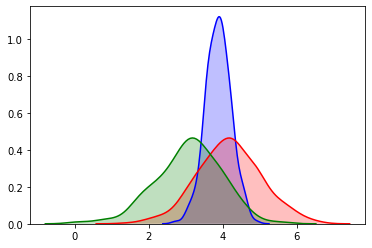

In [30]:
colors= ["b","r","g","y"]
temp_express = rev_gen_samples[:,0]
x = [[temp_express[i] for i in  range(len(temp_express)) if generated_labels[i] == c] for c in range(3)]
[sns.kdeplot(x[i], shade=True, color=colors[i]) for i in range(3)]
for c in combinations(range(len(x)),2):
    print("t-test between ",c[0],"and ",c[1],": ", stats.ttest_ind(x[c[0]],x[c[1]],equal_var=False))


Since the distributions for the same gene are pretty different I dont think it would be appropriate to try to use generated data. This most likley also holds for other genes as well becauset the process relies on a couple of key assumptions. One that the data is normally distributed, and two that there is no information loss when you inverse transform the data. The first most likley doestn hold ovar all of the genes present in the data. The second doesnt hold because the pca was only fitted based on the original genes given from the dataset. I think if I want an approach like this to be feasable, I'd have to make a mixture model over all of the genes which is computationally infeasable with my resources if I want to capture all of the covariances accurately. Instead maybe there is a technique using KDE where you can sample points from each distribution given the set of all other possible genes. So maybe, sample a bunch of points from each disttibution, and have a mechanism to determine whether the point is valid or not, then if it is keep it if not discard it.

### KDE Sampling Experiments

In [41]:
for_kde = df.values
kde_list = []
for i in range(len(for_kde[0])):
    single_gene_data = for_kde[:,i]
    kde = KernelDensity()
    kde.fit(single_gene_data.reshape(-1, 1))
    kde_list.append(kde)

In [76]:
from sklearn.ensemble import IsolationForest
iso =IsolationForest()
iso.fit(df.values)

def is_anomoly(s):
    return True if iso.predict(s) == 1 else False
    
def generate_samples(samples=1):
    sample_list = []
    while len(sample_list) < samples:
        sample = [k.sample()[0] for k in kde_list]
        sample = np.asarray(sample).reshape(len(sample))
        if not is_anomoly(sample):
            sample_list.append(sample)
            
    return np.asarray(sample_list)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


In [85]:
gen_sample_2 = generate_samples(3)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


In [86]:
print(len(gen_sample_2))
print(gen_sample_2.shape)
temp = gen_sample_2[:,0,0]
print(temp.shape)

3
(3, 1, 20529)
(3,)


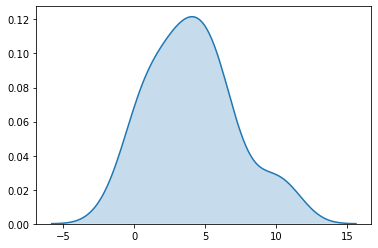

In [79]:
sns.kdeplot(gen_sample_2[:,0,0], shade=True)

This method actually seems to generate more accurate and realistic values than the other generating method, however it takes far longer. Could potentially be used however...

In [81]:
gen_pca = PCA(n_components=3)
gen_pca_pts = gen_pca.fit_transform(gen_sample_2[:,0])

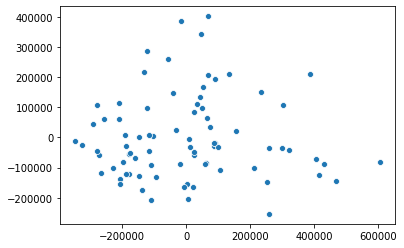

In [82]:
sns.scatterplot(gen_pca_pts[:,0],gen_pca_pts[:,1])

Pca transform looks a little off, might not be a be a good approach after all. 

# Week 2 Experiments

### Normalize data

In [98]:
norm_gene_expression = td.df_normalization(df,"minmax")
norm_gene_expression = norm_gene_expression.values

### Find 80% explained variance

In [99]:
p = PCA(n_components=3)
p.fit(norm_gene_expression)
print(sum(p.explained_variance_ratio_))

0.39736646087007155


In [104]:
l = []
for n in range(1,36):
    p = PCA(n_components=n)
    p.fit(norm_gene_expression)
    l.append(sum(p.explained_variance_ratio_))
    if l[n-1] >.8:
        print(n)

30
31
32
33
34
35


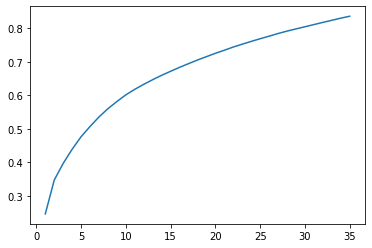

In [105]:
sns.lineplot(range(1,36),l)

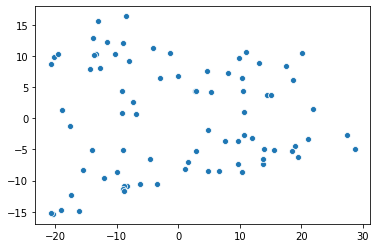

In [106]:
p = PCA(n_components=30)
temp = p.fit_transform(norm_gene_expression)

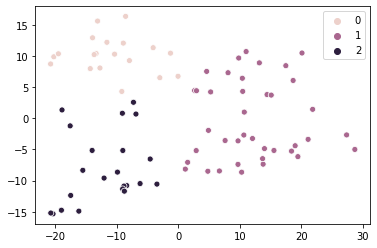

In [113]:
b = BayesianGaussianMixture(n_components=3, n_init=3, random_state=1)
b_class = b.fit_predict(temp)
sns.scatterplot(temp[:,0],temp[:,1],hue=b_class)

### Compute Fraction of Variance Explained 

In [160]:
from sklearn.cluster import KMeans
def SSE(points, labels, centers):
    total_error = 0
    data_mean = np.mean(points) 
    for i in range(len(points)):
        total_error += sum((points[i]-data_mean)**2)
    return total_error

def SSE_bet(points, labels, centers):
    total_error = 0
    data_mean = np.mean(points) 
    
    for k in range(len(centers)):
        n = sum([1 for l in labels if l == k])
        total_error += n*(sum((centers[k]-data_mean)**2))
    return total_error

In [161]:
l = []
for i in range(1,15):
    km = KMeans(n_clusters=i)
    t = km.fit_predict(temp)
    l.append(SSE_bet(temp,t,km.cluster_centers_)/SSE(temp,t,km.cluster_centers_))

[3.298108165502854e-33, 0.2416923724602674, 0.3262818635677688, 0.36842980843559076, 0.39316871489476335, 0.44083942840228646, 0.47883721881476804, 0.4919905314562643, 0.5118622148176829, 0.532460024262321, 0.5528060477502386, 0.5679506854130737, 0.5865756015399315, 0.5980718768651796]


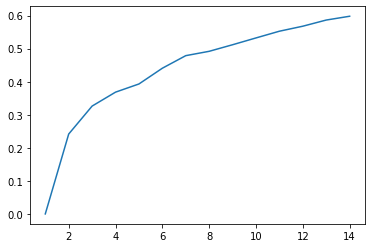

In [162]:
print(l)
sns.lineplot(range(1,15),l)

### Results from elbow method
The results arent totally conclusive, the elbow isnt very definitive so therefore I think there is an acceptable range for the number k for Kmeans or the number of mixtures. The range lies somewhere in between 3-5. Going along with 3, I will do the same thing as above where I split results based on certain genes and see which ones have the highest entropy.
### Decision Tree Discovery

In [165]:
def plot_and_test(expression_df, gene_name, subgroups,labels):
    x = []
    colors= ["b","r","g","y"]
    temp = expression_df.loc[[gene_name]].values[0]
    p = list(expression_df.columns)
    grps = list(subgroups.keys())
    for l in labels:
        x.append([temp[p.index(s[1])] for s in subgroups[group]])
    for group in grps:
        x.append([temp[p.index(s[1])] for s in subgroups[group]])
    [sns.kdeplot(x[i],shade=True,color=colors[i]) for i in range(len(x))]
    for c in combinations(range(len(x)),2):
        print("non-param t-test between ",grps[c[0]],"and ",grps[c[1]],": ", mannwhitneyu(x[c[0]],x[c[1]]))

In [191]:
norm_pca = PCA(n_components=30,random_state=1)
norm_transformed = norm_pca.fit_transform(norm_gene_expression)
norm_km = KMeans(n_clusters=4)
norm_labels = norm_km.fit_predict(norm_transformed)
norm_tree = DecisionTreeClassifier(max_depth=2, random_state=1)
norm_tree.fit(norm_gene_expression ,norm_labels)
tree_to_code(norm_tree, [str(a) for a in df.columns])

  if PTPN23 <= 0.0760640874505043:
    if CELF2 <= 0.12175354734063148:
      return [[0. 1. 0. 0.]]
    else:  # if CELF2 > 0.12175354734063148
      return [[ 0.  0. 23.  0.]]
  else:  # if PTPN23 > 0.0760640874505043
    if RSRC1 <= 0.24901565164327621:
      return [[18.  0.  0. 20.]]
    else:  # if RSRC1 > 0.24901565164327621
      return [[ 0. 18.  0.  0.]]


### Plot using not normalized method

FAM127C
t-test between  0 and  1 :  Ttest_indResult(statistic=-4.782572464480745, pvalue=2.7449472757587754e-05)
t-test between  0 and  2 :  Ttest_indResult(statistic=4.001840961685449, pvalue=0.0003479470355643227)
t-test between  0 and  3 :  Ttest_indResult(statistic=4.500098887519768, pvalue=6.826889973516665e-05)
t-test between  1 and  2 :  Ttest_indResult(statistic=8.569522449808488, pvalue=6.066574087437261e-09)
t-test between  1 and  3 :  Ttest_indResult(statistic=8.855865139064283, pvalue=1.384339802673461e-09)
t-test between  2 and  3 :  Ttest_indResult(statistic=1.015999830603481, pvalue=0.3169611360392038)


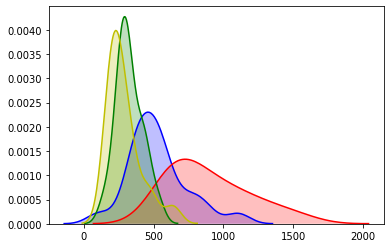

In [189]:
plot_dist_and_test(4,"FAM127C",norm_labels)

PTPN23
t-test between  0 and  1 :  Ttest_indResult(statistic=-7.014203633603206, pvalue=4.868540976791241e-09)
t-test between  0 and  2 :  Ttest_indResult(statistic=-8.788375150947099, pvalue=1.1632239783184746e-08)
t-test between  1 and  2 :  Ttest_indResult(statistic=-6.091446245380794, pvalue=2.1624029140025415e-06)


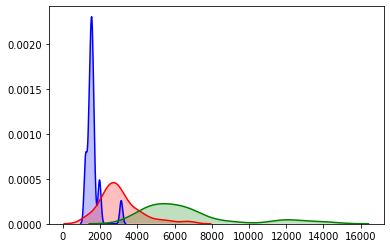

In [169]:
plot_dist_and_test(3,"PTPN23")

### Plot after values normalized

PTPN23
t-test between  0 and  1 :  Ttest_indResult(statistic=8.370037146500936, pvalue=4.5317820542584493e-10)
t-test between  0 and  2 :  Ttest_indResult(statistic=5.293314101414829, pvalue=3.2251927950907925e-06)
t-test between  1 and  2 :  Ttest_indResult(statistic=-6.640609025031329, pvalue=4.583318696229513e-07)


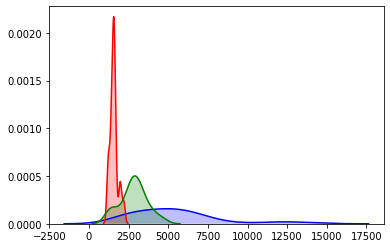

In [174]:
plot_dist_and_test(3,"PTPN23",norm_labels)

## Interesting genes
- PTPN23
- FAM127C 